In [3]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../src')
import harmoutil

%matplotlib inline

In [4]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../src/harmoutil.py'>

In [6]:
### Load raw data ###
raw_data = harmoutil.load_pickled_data("../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections

### Augment data ###
augmented_data = harmoutil.transpose_and_augment_data(raw_data)

data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

chords = [ch for section in data for ch, mel in section]
melodies_by_beats = [mel for section in data for ch, mel in section]

melodies_by_notes = []
for mel in melodies_by_beats:
    melodies_by_notes.append([n for b in mel for n in b])
notes = [n for sec in melodies_by_notes for n in sec]
print(len(chords), len(melodies_by_beats), len(melodies_by_notes), len(notes))

334344 334344 334344 2209944


<Figure size 432x288 with 0 Axes>

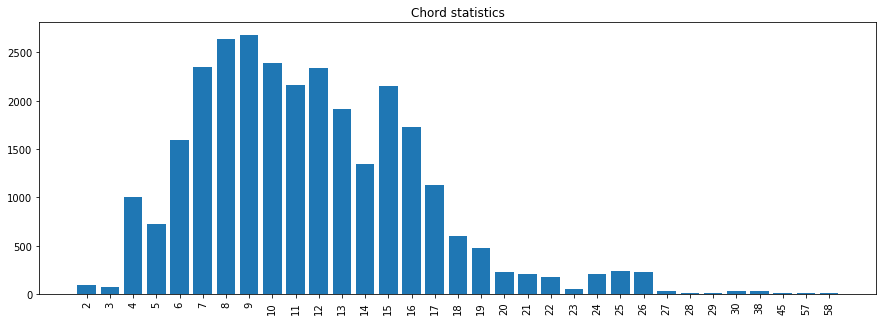

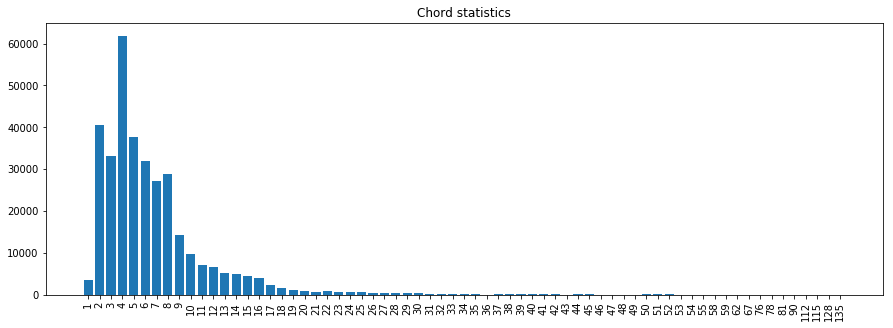

In [7]:
### Visualize classes statistics ###

chord_seq_lengths = [len(section) for section in data]

plt.clf()

labels = sorted(list(set(chord_seq_lengths)))
x_axis = range(len(labels))
y_axis = [chord_seq_lengths.count(lab) for lab in labels]

plt.figure(figsize=(15,5))
plt.bar(x_axis, y_axis, tick_label=labels)
plt.xticks(rotation='vertical')
plt.title('Chord statistics')
plt.show()


melody_seq_lengths = [len(sec) for sec in melodies_by_notes]
    
labels = sorted(list(set(melody_seq_lengths)))
x_axis = range(len(labels))
y_axis = [melody_seq_lengths.count(lab) for lab in labels]

plt.figure(figsize=(15,5))
plt.bar(x_axis, y_axis, tick_label=labels)
plt.xticks(rotation='vertical')
plt.title('Chord statistics')
plt.show()

In [8]:
### Define class integer mappings ###
notes_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(notes)))[1:])])
notes_index[-1] = len(notes_index)
notes_index['<end>'] = len(notes_index)
notes_index['<pad>'] = len(notes_index)

index_notes = dict(
    [(v, k) for k, v in notes_index.items()])


chords_index = dict(
    [(c, i) for i, c in enumerate(sorted(list(set(chords))))])
chords_index['<bos>'] = len(chords_index)
chords_index['<eos>'] = len(chords_index)

index_chords = dict(
    [(v, k) for k, v in chords_index.items()])

In [9]:
### Numerical variables ###
n_chords = len(chords_index)
n_notes = len(notes_index)
max_melody_seq_len = max([len(mel) for mel in melodies_by_notes])
max_chords_seq_len = max([len(section) for section in data])
ch_context_window = 7


print("Total number of distinct chord labels:", n_chords)
print("Total number of distinct melody notes:", n_notes)
print("Maximum length of melody sequences:", max_melody_seq_len)
print("Maximum length of chord sequences:", max_chords_seq_len)
print("Number of chords taken into account for next prediction:", ch_context_window)

Total number of distinct chord labels: 195
Total number of distinct melody notes: 15
Maximum length of melody sequences: 135
Maximum length of chord sequences: 58
Number of chords taken into account for next prediction: 7


In [10]:
### Build tensors ###


# Build data lists
input_melody_eos = []
input_chords_eos = []
target_chords_eos = []

for section in data:
    chord_sequence = [ch for ch, mel in section]
    padded_sequence = ['<bos>']*ch_context_window + chord_sequence + ['<eos>']
    for i in range(len(chord_sequence)+1):
        input_chords_eos.append(padded_sequence[i:i+ch_context_window])
        target_chords_eos.append(padded_sequence[i+ch_context_window])

    chord_mel = [mel for ch, mel in section]
    melody_sequence = []
    for mel in chord_mel:
        ch_mel = []
        for b in mel:
            for n in b:
                ch_mel.append(n)
        melody_sequence.append(ch_mel)
    melody_sequence += [['<end>']]
    input_melody_eos += melody_sequence
    
    
# for i in range(len(data[0])+1):
#     print(input_melody[i], input_chords[i], target_chords[i])
# print(len(input_melody), len(input_chords), len(target_chords))
    
# Remove any 
print(len(target_chords_eos), len(input_chords_eos), len(input_melody_eos))
target_chords = [target_chords_eos[i] for i in range(len(target_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_chords = [input_chords_eos[i] for i in range(len(input_chords_eos)) if not target_chords_eos[i] == '<eos>']
input_melody = [input_melody_eos[i] for i in range(len(input_melody_eos)) if not target_chords_eos[i] == '<eos>']
print(len(target_chords), len(input_chords), len(input_melody))
    
    
n_entries = len(target_chords)

X_melody = np.zeros((n_entries, max_melody_seq_len, n_notes), dtype='float32')
X_chords = np.zeros((n_entries, ch_context_window, n_chords), dtype='float32')
Y = np.zeros((n_entries, n_chords), dtype='float32')



for i, (in_mel, in_ch, tg_ch) in enumerate(zip(input_melody, input_chords, target_chords)):
    Y[i, chords_index[tg_ch]] = 1
    for j, ch in enumerate(in_ch):
        X_chords[i, j, chords_index[ch]] = 1
        
    padded_melody = in_mel + ['<pad>']*(max_melody_seq_len - len(in_mel))
    for k, note in enumerate(padded_melody):
        X_melody[i, k, notes_index[note]] = 1
            
print(int(np.sum(X_melody)), n_entries*max_melody_seq_len)
print(int(np.sum(X_chords)), n_entries*ch_context_window)
print(int(np.sum(Y)), n_entries)


363228 363228 363228
334344 334344 334344
45115280 45136440
2340408 2340408
334344 334344


In [11]:
### Train/Validation/Test sets ###
seed = 1

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in strat_split.split(X_chords, Y):
    X_melody_train = X_melody[train_index]
    X_chords_train = X_chords[train_index]
    Y_train = Y[train_index]
    
    X_melody_aux = X_melody[aux_index]
    X_chords_aux = X_chords[aux_index]
    Y_aux = Y[aux_index]
    
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)
for valid_index, test_index in strat_split.split(X_chords_aux, Y_aux):
    X_melody_valid = X_melody_aux[valid_index]
    X_chords_valid = X_chords_aux[valid_index]
    Y_valid = Y_aux[valid_index]
    
    X_melody_test = X_melody_aux[test_index]
    X_chords_test = X_chords_aux[test_index]
    Y_test = Y_aux[test_index]

print(X_melody_train.shape, X_chords_train.shape, Y_train.shape)
print(X_melody_valid.shape, X_chords_valid.shape, Y_valid.shape)
print(X_melody_test.shape, X_chords_test.shape, Y_test.shape)

# train_size = melody_train.shape[0]
# test_size = melody_test.shape[0]

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [10]:
### Define neural net architectur ###
latent_dim = 128

melody_input = Input(shape=(max_melody_seq_len, n_notes))
melody_gru = GRU(latent_dim)(melody_input)

chords_input = Input(shape=(ch_context_window, n_chords))
chords_gru = GRU(latent_dim)(chords_input)

concat = concatenate([melody_gru, chords_gru])

chord_dense = Dense(n_chords, activation='softmax')(concat)

model = Model([melody_input, chords_input], chord_dense)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 135, 15)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 195)        0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 128)           55296       input_1[0][0]                    
____________________________________________________________________________________________________
gru_2 (GRU)                      (None, 128)           124416      input_2[0][0]                    
___________________________________________________________________________________________

In [10]:
### Introduce Early-Stopping and Save Best Performance callbacks ###
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "../../models/seventh_cc-7.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [11]:
### Train model ###
batch_size = 32
epochs = 50

history = model.fit([X_melody_train, X_chords_train], Y_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_valid,), batch_size=batch_size, callbacks=[es, bp])

Train on 267475 samples, validate on 33434 samples
Epoch 1/50
267475/267475 [==============================] - 1368s - loss: 2.6053 - acc: 0.4018 - val_loss: 2.2735 - val_acc: 0.4572
Epoch 2/50
267475/267475 [==============================] - 1369s - loss: 2.1020 - acc: 0.4966 - val_loss: 2.0034 - val_acc: 0.5229
Epoch 3/50
267475/267475 [==============================] - 1373s - loss: 1.8604 - acc: 0.5524 - val_loss: 1.8481 - val_acc: 0.5583
Epoch 4/50
267475/267475 [==============================] - 1378s - loss: 1.6917 - acc: 0.5919 - val_loss: 1.7212 - val_acc: 0.5904
Epoch 5/50
267475/267475 [==============================] - 1381s - loss: 1.5696 - acc: 0.6198 - val_loss: 1.6490 - val_acc: 0.6100
Epoch 6/50
267475/267475 [==============================] - 1383s - loss: 1.4835 - acc: 0.6395 - val_loss: 1.5993 - val_acc: 0.6222
Epoch 7/50
267475/267475 [==============================] - 1386s - loss: 1.4408 - acc: 0.6513 - val_loss: 1.5819 - val_acc: 0.6273
Epoch 8/50
267475/267475 

267475/267475 [==============================] - 1360s - loss: 0.8935 - acc: 0.7582 - val_loss: 1.2471 - val_acc: 0.7079
Epoch 29/50
267475/267475 [==============================] - 1361s - loss: 0.8950 - acc: 0.7581 - val_loss: 1.2330 - val_acc: 0.7120
Epoch 30/50
267475/267475 [==============================] - 1364s - loss: 0.8791 - acc: 0.7620 - val_loss: 1.2332 - val_acc: 0.7136
Epoch 31/50
267475/267475 [==============================] - 1365s - loss: 0.8762 - acc: 0.7622 - val_loss: 1.2348 - val_acc: 0.7112
Epoch 32/50
267475/267475 [==============================] - 1367s - loss: 0.8998 - acc: 0.7565 - val_loss: 1.2519 - val_acc: 0.7090
Epoch 33/50
267475/267475 [==============================] - 1365s - loss: 0.8919 - acc: 0.7577 - val_loss: 1.2510 - val_acc: 0.7117
Epoch 34/50
267475/267475 [==============================] - 1360s - loss: 0.8809 - acc: 0.7605 - val_loss: 1.2364 - val_acc: 0.7123
Epoch 35/50
267475/267475 [==============================] - 1362s - loss: 0.9592

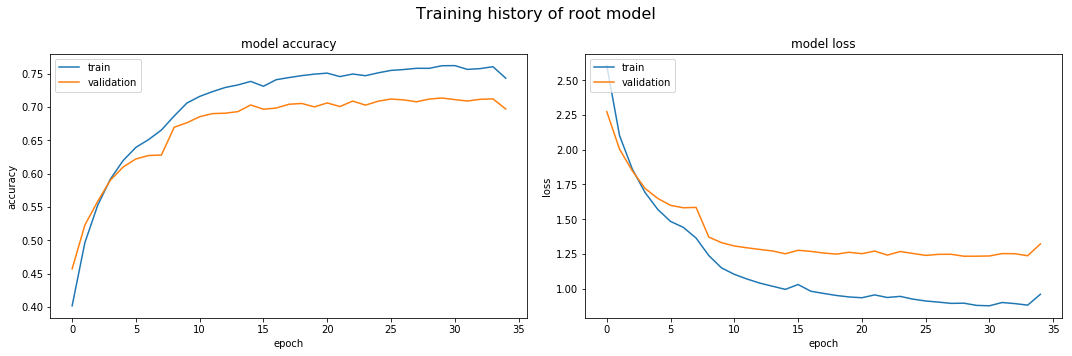

In [12]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [12]:
### Load best performance model ###
model = load_model("../../models/seventh_cc-7.h5")

In [13]:
### Evaluate predictions ###

# Predict chords from each test sample melody
chord_pred = model.predict([X_melody_test, X_chords_test])

    
# Compute accuracy and kappa score 
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_test, chord_pred)))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_test, chord_pred)))

Categorical accuracy of combined chord prediction: 0.7123
Kappa score of combined chord prediction: 0.7049


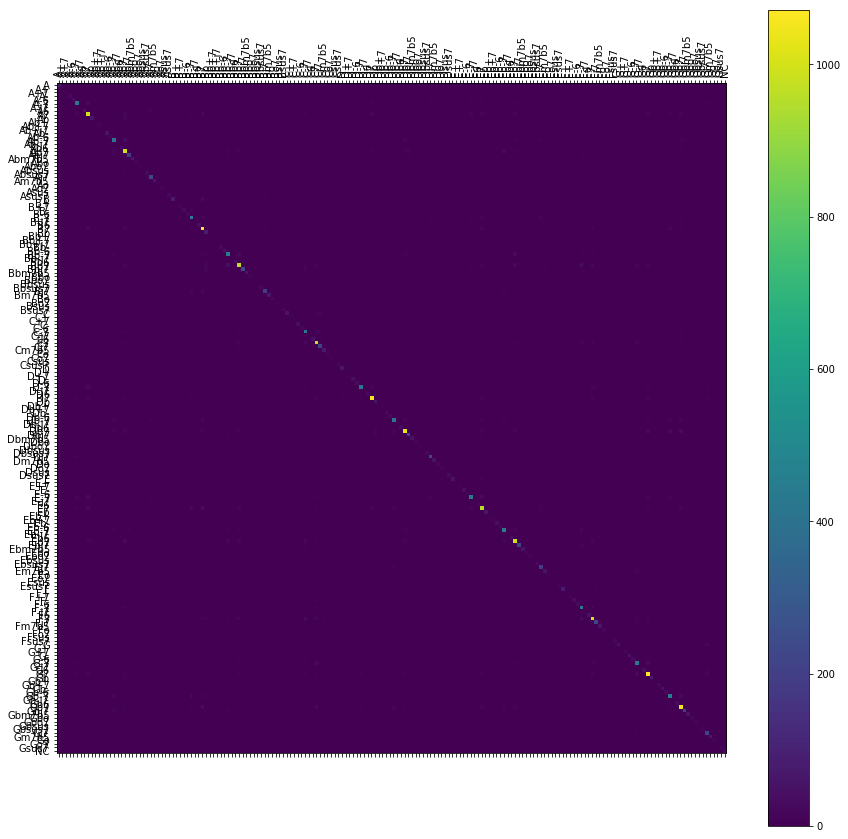

In [14]:
### Visualize prediction ###
chord_test_labels = [index_chords[np.argmax(row)] for row in Y_test]
chord_pred_labels = [index_chords[np.argmax(row)] for row in chord_pred]

chord_cm = confusion_matrix(chord_test_labels, chord_pred_labels)

labels = sorted(list(set(chord_test_labels)))
# print(labels)
plt.figure(figsize=(15,15))              
ax = plt.axes()                 
im = ax.matshow(chord_cm)      
plt.colorbar(im, ax=ax)               
plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
plt.yticks(np.arange(len(labels)), labels)
plt.show()


In [15]:
### Evaluate performnce in terms of note presence ###

# Convertroot+suffix prediction to note presence vector (as in Model 4)
converted_preds_list = []
for ch in chord_pred:
    chord_label = index_chords[np.argmax(ch)]
    note_presence = harmoutil.chord_to_notes(chord_label)
    converted_preds_list.append(note_presence)
    
    
# Convert original groundtruth test set chords to note presence vector (as in Model 4)
converted_trues_list = []
for row in Y_test:
    prediction = index_chords[np.argmax(row)]
    note_presence = harmoutil.chord_to_notes(prediction)
    converted_trues_list.append(note_presence)
    
# Create tesnsors of converted data
converted_preds = np.zeros((Y_test.shape[0], 12), dtype='float32')
converted_trues = np.zeros((Y_test.shape[0], 12), dtype='float32')
for i, (pred, true) in enumerate(zip(converted_preds_list, converted_trues_list)):
#     print(pred)
    for j, pred_pres in enumerate(pred):
#         print(j, pred_pres)
        converted_preds[i, j] = pred_pres
    for k, true_pres in enumerate(true):
        converted_trues[i, k] = true_pres
        
# Compute accuracy
print("Accuracy: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(converted_trues, converted_preds)))
print("Kappa: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(converted_trues, converted_preds)))
        

Accuracy: 0.8810
TP: 107174 TN: 246297 FP: 24107 FN: 23642
269939 270404
131281 130816
Kappa: 0.7295


In [16]:
counts = []
for row in converted_preds:
    result = []
    count = 0
    for note in row:
        result.append(round(note))
        count += note
    counts.append(count)
#     print(result)
print("Avg notes per prediction:", sum(counts)/len(counts))

Avg notes per prediction: 3.9264543143412594


In [17]:
print("F-score: {0:.4f}".format(harmoutil.compute_binary_fscore(converted_trues, converted_preds)))

F-score: 0.8178


In [21]:
### Check inter-chord performance ###

# 
miss_pred = []
miss_test = []
miss_pred_pitches = []
miss_test_pitches = []
miss_labels = []
count = 0
for pred_lab, test_lab in zip(chord_pred_labels, chord_test_labels):
    if not pred_lab == test_lab:
        miss_labels.append(pred_lab)
        miss_labels.append(test_lab)

        miss_pred.append(pred_lab)
        miss_test.append(test_lab)
        
        miss_pred_pitches.append(harmoutil.chord_to_notes(pred_lab))
        miss_test_pitches.append(harmoutil.chord_to_notes(test_lab))
        
        count+=1

print(count)
print(len(list(set(miss_labels))))


def chord_grader(pred, test):
    score = 0
    for pr_pitch, te_pitch in zip(pred, test):
        score += int((pr_pitch == te_pitch) and pr_pitch == 1)
    return score

scores = []
for pred_pitches, test_pitches in zip(miss_pred_pitches, miss_test_pitches):
#     print(pred_pitches, test_pitches)
    scores.append(chord_grader(pred_pitches, test_pitches))

print("Avg score:", sum(scores)/len(scores))
print("Std:", ((1/len(scores))*sum([(i-sum(scores)/len(scores))**2 for i in scores]))**(1/2))
# miss_chord_cm = confusion_matrix(miss_test, miss_pred)
# labels = sorted(list(set(miss_labels)))
# # print(labels)
# plt.figure(figsize=(15,15))              
# ax = plt.axes()                 
# im = ax.matshow(miss_chord_cm)      
# plt.colorbar(im, ax=ax)               
# plt.xticks(np.arange(len(labels)), labels, rotation='vertical')
# plt.yticks(np.arange(len(labels)), labels)
# plt.show()

9620
172
Avg score: 1.4112266112266112
Std: 0.9906626190276788


In [22]:
### pick random start from the test data ###
seq_seed = 42

random.seed(seq_seed)
random_index = random.randint(0, X_chords_test.shape[0]-1)
X_initial_seq = X_chords_test[random_index]
print(X_initial_seq.shape)

(7, 195)


In [28]:
### Afternoon in Paris ###

# build script that uses prediction function

aip_melody = [[2, 0, 11, 0, 2, 4], [3, 7, 10, 2], [0, 2, 5], [0, 10, 9, 10, 0, 2], [1, 5, 8, 0], [10, 0, 3], [10, 8, 3, 7, 10, 8, 5], [-1], [7, 5, 7], [4, 7, 11, 2], [0, 2, 4, 7], [5, 9, 0, 4, 2], [4, 7]]
aip_chords = ['Cj7', 'C-7', 'F7', 'Bbj7', 'Bb-7', 'Eb7', 'Abj7', 'D-7', 'G7', 'Cj7', 'A-7', 'D-7', 'G7']

    
def build_mel_tensor(mel):
    padded_mel = mel + ['<pad>']*(max_melody_seq_len - len(mel))
    X_mel = np.zeros((1, max_melody_seq_len, n_notes), dtype='float32')
    for k, note in enumerate(padded_mel):
        X_mel[0, k, notes_index[note]] = 1
    return X_mel
    

def build_ch_tensor(in_ch):
    X_ch = np.zeros((1, ch_context_window, n_chords), dtype='float32')
    for j, ch in enumerate(in_ch):
        X_ch[0, j, chords_index[ch]] = 1
    return X_ch


harmony = []
past_chords = ['<bos>']*(ch_context_window)

# past_chords = [index_chords[np.argmax(i)] for i in X_initial_seq]
# past_chords = X_initial_seq
print(past_chords)
for mel_notes in aip_melody:
    input_ch = build_ch_tensor(past_chords)                  # build past chords tensor
    input_mel = build_mel_tensor(mel_notes)                  # build tensor for current melody
    next_pred = model.predict([input_mel, input_ch])         # predict target chord from current melody and past chords
    next_chord = index_chords[np.argmax(next_pred)]          # convert prediction to chord label 
    past_chords = past_chords[1:]+[next_chord]               # update past chord sequence with newly predicted chord
    harmony.append(next_chord)                               # append new chord label to harmony list
    
print(harmony)

['<bos>', '<bos>', '<bos>', '<bos>', '<bos>', '<bos>', '<bos>']
['A-7', 'C-7', 'F7', 'Bbj7', 'B-7', 'E7', 'A-7', 'D7', 'Gj7', 'E-7', 'A7', 'D7', 'A-7']


In [30]:
for ham in harmony:
    print(ham, harmoutil.chord_to_notes(ham))

A-7 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
C-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
F7 [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Bbj7 [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
B-7 [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
E7 [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0]
A-7 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]
D7 [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
Gj7 [1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0]
E-7 [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
A7 [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
D7 [0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0]
A-7 [0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]


In [36]:
for ham in harmony:
    print(ham, harmoutil.chord_to_notes(ham))

A-7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
C-7 [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0]
F7 [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Bbj7 [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0]
B-7 [0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1]
E7 [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1]
A-7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
D7 [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Gj7 [0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
E-7 [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1]
A7 [0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
D7 [1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
A-7 [1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0]
